In [1]:
import sys
import os

# Add the mem_train folder to the system path.
mem_train_dir = os.path.join(os.getcwd(), "mem_train")
if mem_train_dir not in sys.path:
    sys.path.insert(0, mem_train_dir)

print("sys.path:", sys.path[:5])


sys.path: ['/home/marmot/Boyang/MEM-Nav/mem_train', '/home/marmot/anaconda3/envs/mem-nav/lib/python39.zip', '/home/marmot/anaconda3/envs/mem-nav/lib/python3.9', '/home/marmot/anaconda3/envs/mem-nav/lib/python3.9/lib-dynload', '']


In [3]:
import os
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

# Assuming your notebook is in the project root (/home/marmot/Boyang/MEM-Nav)
# and you already added mem_train to sys.path above, you now import modules without the 'mem_train.' prefix.
from mem_vae_utils import load_instructblip_model_lavis, prepare_blip2_embeddings, generate_mem_prompt
from blip2_conditioned_VAE import create_MemMapVAE
from constants import OBJECT_CATEGORIES
from dataset import MEM_build_Dataset
from topdown_map_utils import visualize_sem_map, show_semmap_compare


In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Path to your saved checkpoint (adjust this path as needed)
checkpoint_path = "mem_train/checkpoints/vae_checkpoint_best.pth"# Load the checkpoint.
checkpoint = torch.load(checkpoint_path, map_location=device)

# Retrieve the model configuration from the checkpoint.
model_config = checkpoint["model_config"]
mem_generator, map_vae = create_MemMapVAE(model_config)

map_vae.load_state_dict(checkpoint["map_vae_state_dict"])
mem_generator.load_state_dict(checkpoint["mem_generator_state_dict"])

map_vae.to(device)
mem_generator.to(device)
map_vae.eval()
mem_generator.eval()

MemGenerator(
  (attention_pool): AverageSelfAttention(
    (softmax): Softmax(dim=1)
  )
)

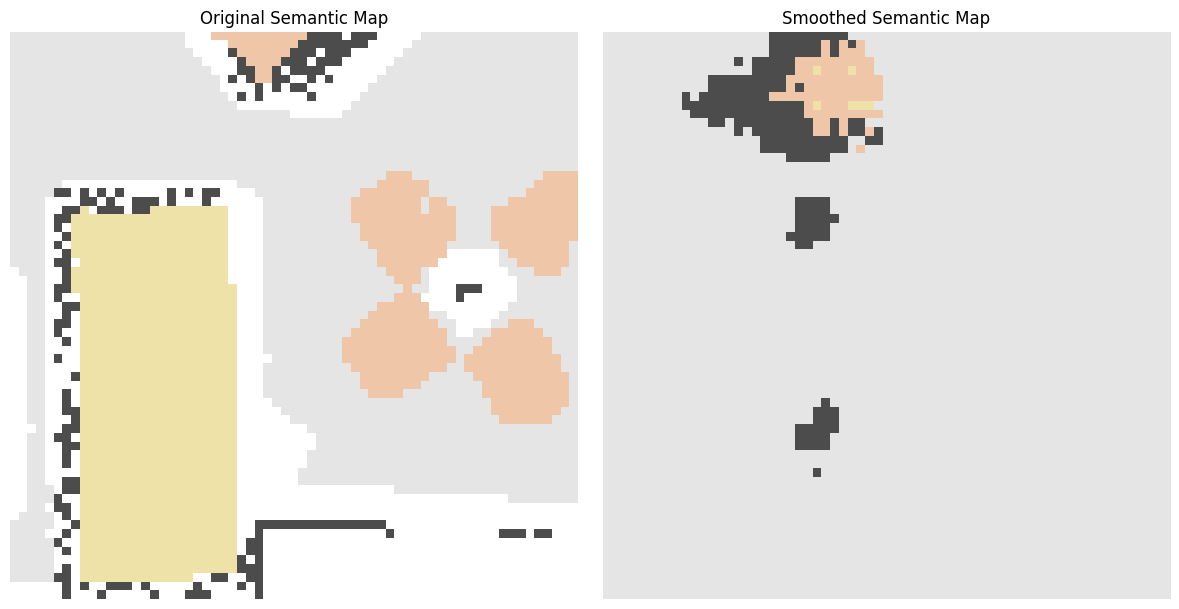

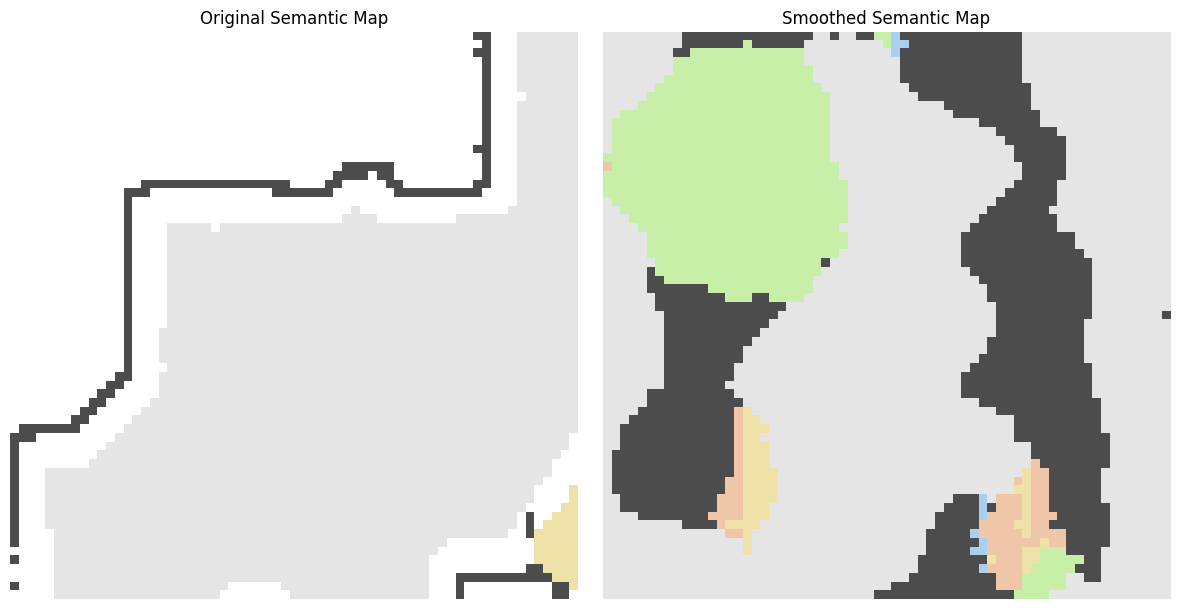

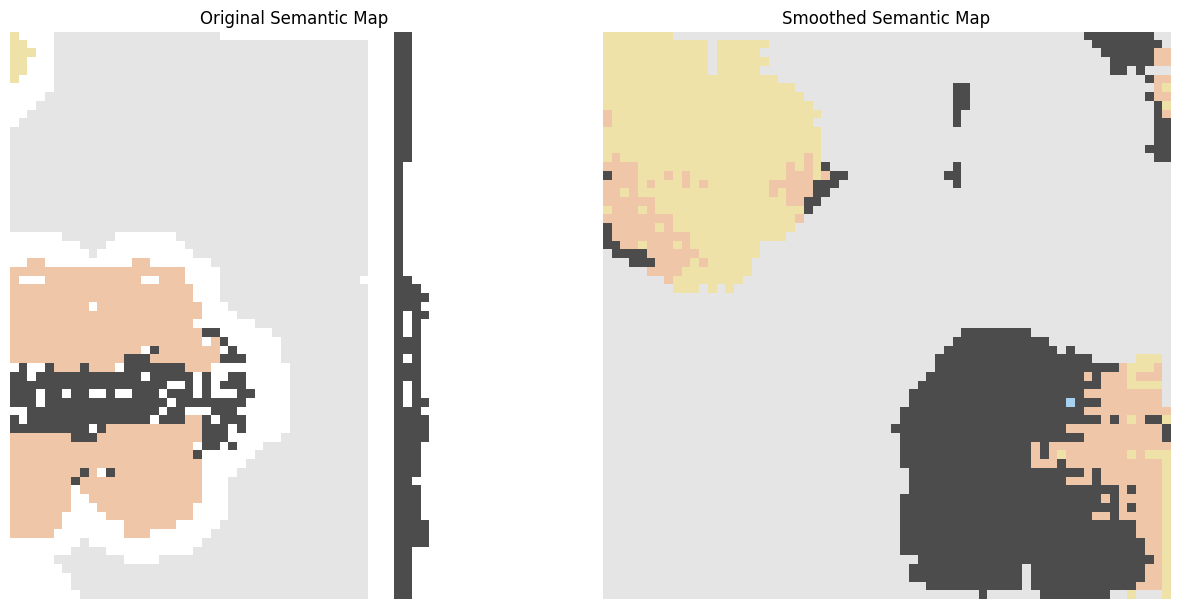

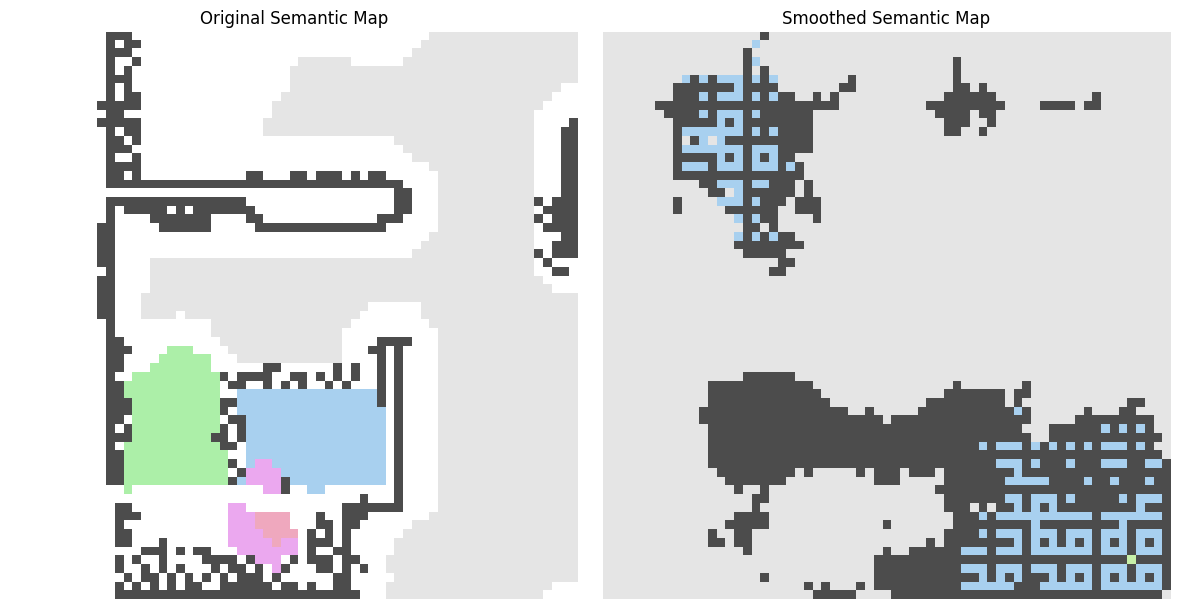

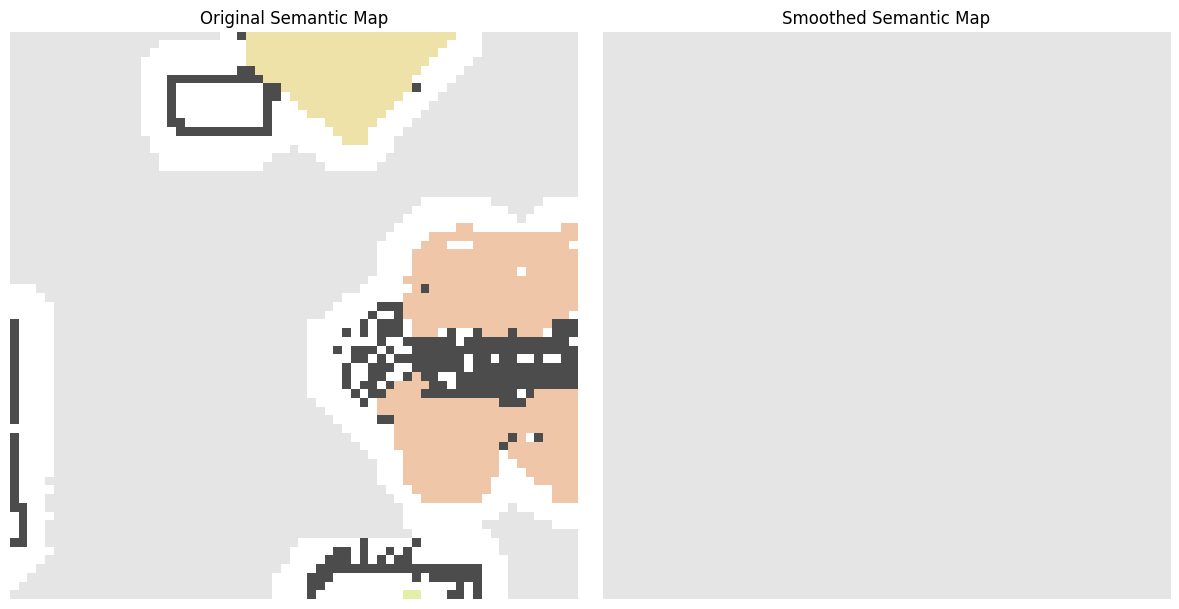

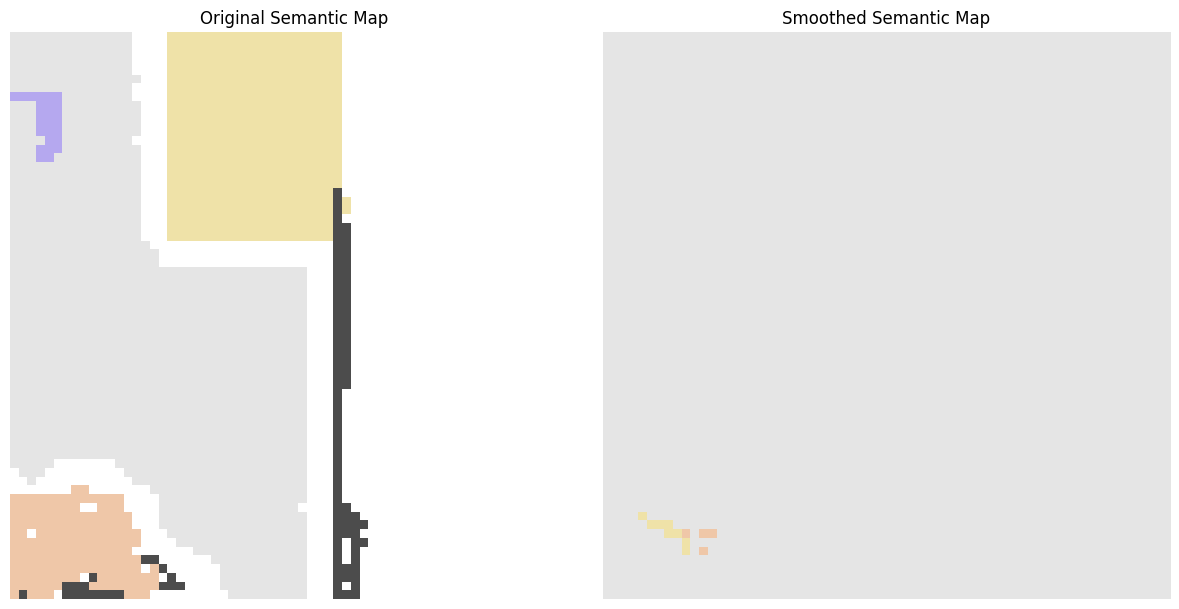

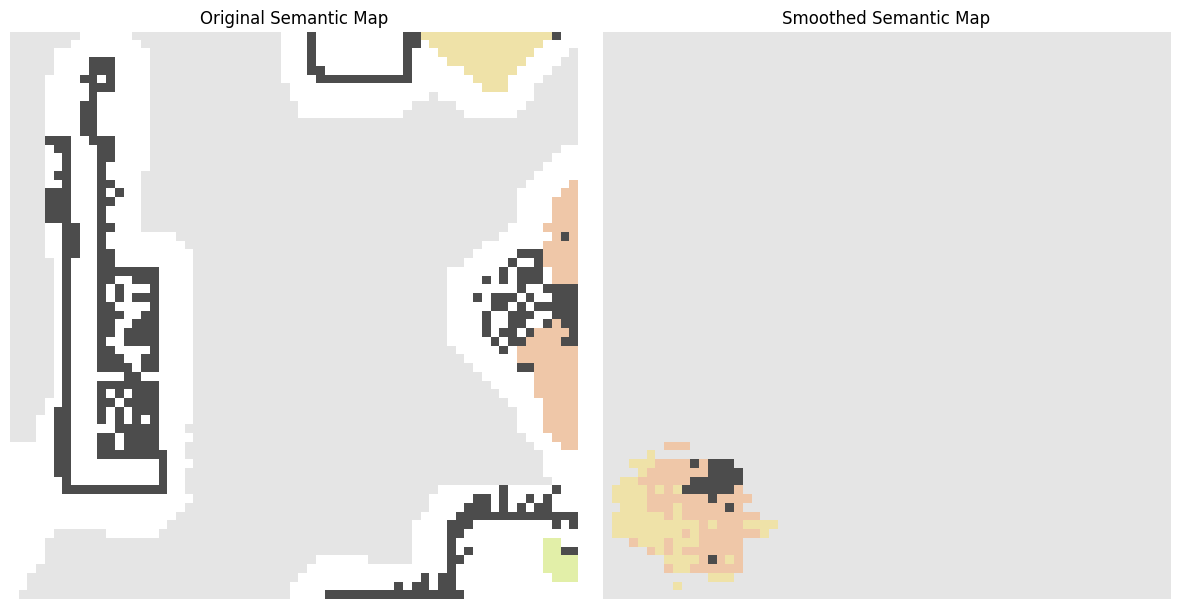

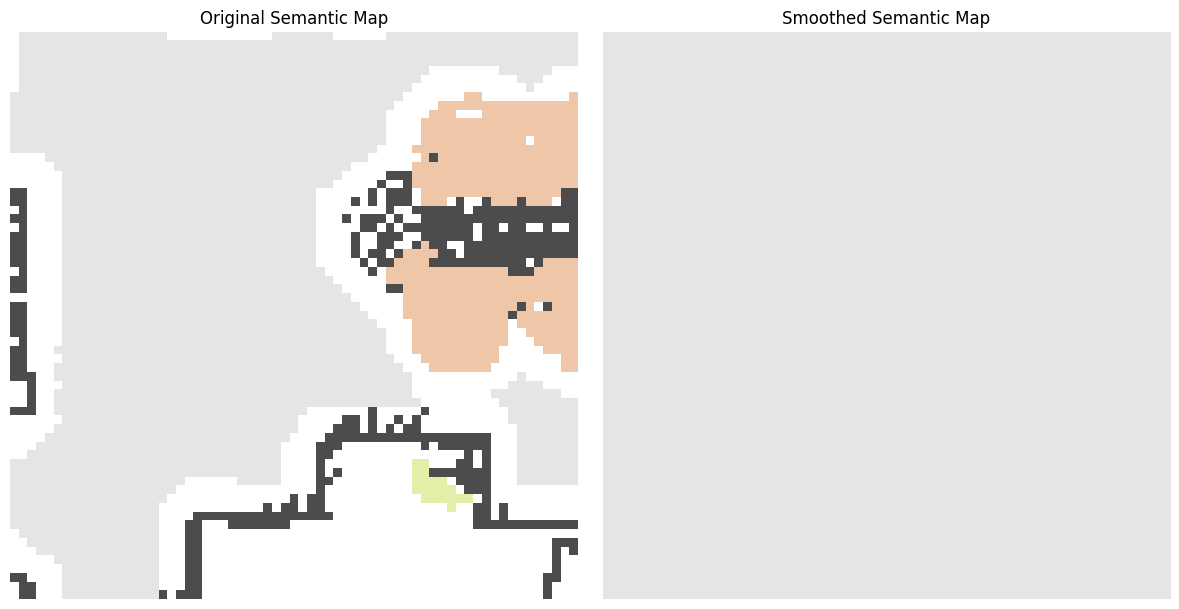

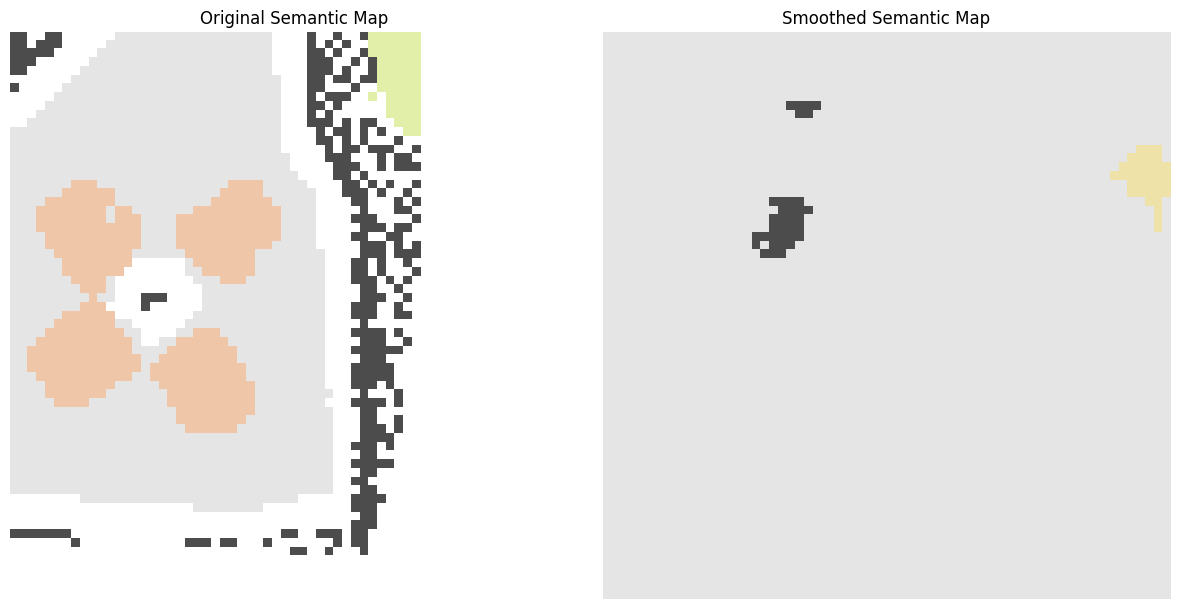

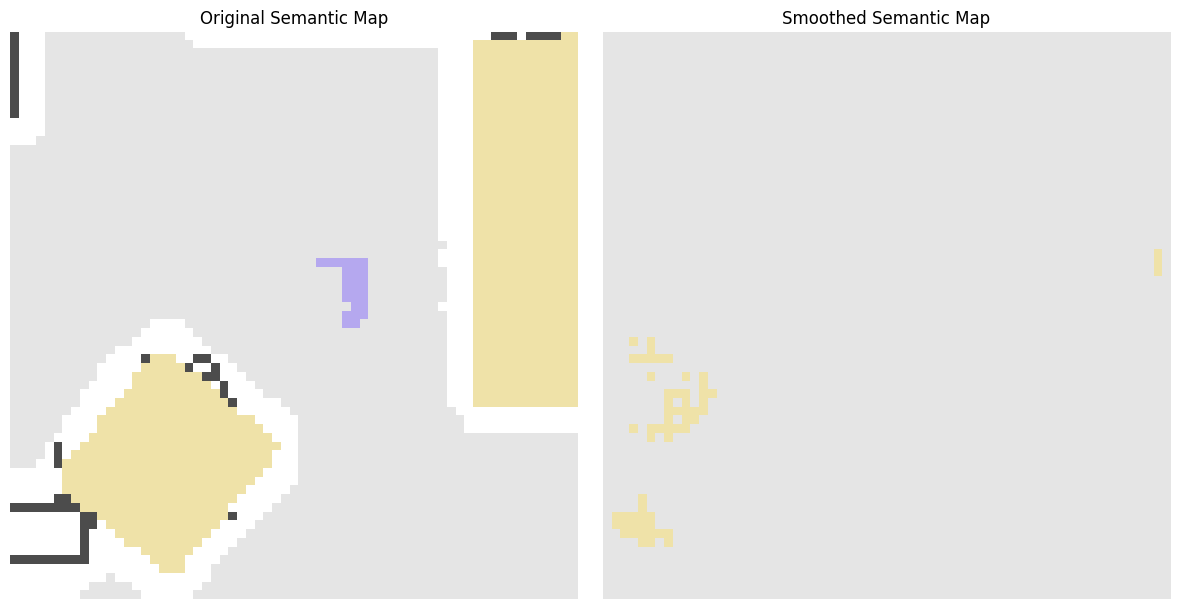

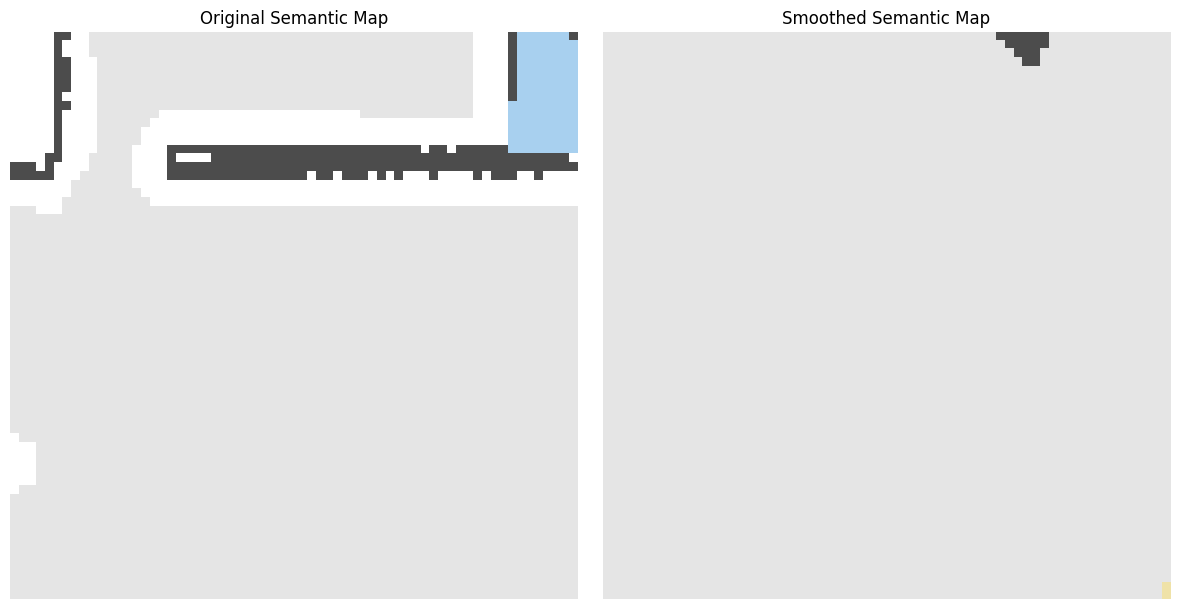

In [6]:
test_dataset = MEM_build_Dataset(
    root_dir="data/semantic_maps/gibson/image_map_pairs",
    split= "test",
    view_wise_oh=False, # False, one hot existence for the whole local map
    shuffle_views=True # randomly shuffle views' order
)
# --- Inference ---
cnt = 0
# Loop over a few test samples.
for data in test_dataset:
    
    local_map_gt = data["local_map"].cpu().numpy()   # (1, 65, 65)
    rgb_views = data["rgb_views"].to(device)     # (4, 3, 1024, 1024)
    
    # Prepare BLIP2 embeddings.
    if "blip2_embeds" in data:
        blip2_embeds = data["blip2_embeds"].to(device)  # (4, 32, 768)
    else:
        try:
            blip2_embeds = prepare_blip2_embeddings(blip2_model, vis_processors, txt_processors, rgb_views, mem_prompt, device=device)
        except:
            blip2_model_name = "blip2_t5_instruct"
            blip2_model, vis_processors, txt_processors = load_instructblip_model_lavis(blip2_model_name)
            blip2_model.to(device)
            mem_prompt = generate_mem_prompt(OBJECT_CATEGORIES["gibson"])
            
    # Generate mem_condition from the MemGenerator.
    mem_condition, _ = mem_generator(blip2_embeds)  # shape: (1, cond_dim)

    # During inference, if no ground truth local map is provided, you can sample a latent vector.
    latent_dim = model_config["latent_dim"]
    z = torch.randn(1, latent_dim).to(device)

    # Decode using the decoder.
    logits = map_vae.decoder(z, mem_condition)  # shape: (1, num_classes, 65, 65)

    # Convert logits to class predictions (argmax over channel dimension).
    predicted_map = torch.argmax(logits, dim=1)  # shape: (1, 65, 65)
    # Convert logits to predicted map.
    pred_map = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()  # (1, 65, 65)
    
    show_semmap_compare(local_map_gt, pred_map)
    plt.show()
    
    cnt += 1
    if cnt > 10:
        break
